1.1 Configuracion de rutas de trabajo

In [48]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Configuración de Directorios 
# Esto busca la carpeta 'data/raw' subiendo un nivel desde 'notebooks'
BASE_DIR = Path.cwd().parent
RAW_DIR = BASE_DIR / "data" / "raw"

print(f"Directorio Base: {BASE_DIR}")
print(f"Ruta de Datos Raw: {RAW_DIR}")

# 2. Verificar que las carpetas existen
carpetas_esperadas = [
    "cbros_ct_datos_cliente_masked",
    "cbros_ct_gestiones_procesadas_masked",
    "cbros_ct_mejor_canal_masked"
]

print("\nVerificando archivos...")
for carpeta in carpetas_esperadas:
    ruta = RAW_DIR / carpeta
    if ruta.exists():
        print(f"Encontrado: {carpeta}")
    else:
        print(f"NO ENCONTRADO: {carpeta} (Revisa el nombre en data/raw)")

Directorio Base: c:\Users\Nicole\Documents\Proyecto_BA
Ruta de Datos Raw: c:\Users\Nicole\Documents\Proyecto_BA\data\raw

Verificando archivos...
Encontrado: cbros_ct_datos_cliente_masked
Encontrado: cbros_ct_gestiones_procesadas_masked
Encontrado: cbros_ct_mejor_canal_masked


1.2 Carga de datos PARQUET y Submission (OOT)

In [49]:
# Función auxiliar para leer datasets particionados
def load_parquet_dataset(folder_name):
    path = RAW_DIR / folder_name
    try:
        # Pandas detecta automáticamente que es una carpeta con parquets
        df = pd.read_parquet(path, engine='pyarrow')
        print(f"Carga Exitosa: {folder_name}")
        print(f"   └── Dimensiones: {df.shape} (Filas, Columnas)")
        return df
    except Exception as e:
        print(f"Error cargando {folder_name}: {e}")
        return None

print("Cargando Datasets (esto puede tardar unos segundos)...")

# 1. Cargar Clientes (Demográficos)
df_clientes = load_parquet_dataset("cbros_ct_datos_cliente_masked")

# 2. Cargar Gestiones (Transaccional - El más pesado)
df_gestiones = load_parquet_dataset("cbros_ct_gestiones_procesadas_masked")

# 3. Cargar Target (Etiquetas de entrenamiento)
df_target = load_parquet_dataset("cbros_ct_mejor_canal_masked")

# 4. Cargar Archivo de Submission (OOT)
oot_file_name = "ids_prueba_ba_mejor_canal_contacto_oot.csv"

try:
    path_oot = RAW_DIR / oot_file_name
    df_oot = pd.read_csv(path_oot)

    print(f"Carga Exitosa: OOT Submission File")
    print(f"   └── Dimensiones: {df_oot.shape}")

except Exception as e:
    print(f"Error: No se pudo cargar el archivo OOT. Verifica el nombre exacto en data/raw. Error: {e}")

Cargando Datasets (esto puede tardar unos segundos)...
Carga Exitosa: cbros_ct_datos_cliente_masked
   └── Dimensiones: (13556034, 42) (Filas, Columnas)
Carga Exitosa: cbros_ct_gestiones_procesadas_masked
   └── Dimensiones: (528546, 8) (Filas, Columnas)
Carga Exitosa: cbros_ct_mejor_canal_masked
   └── Dimensiones: (201979, 3) (Filas, Columnas)
Carga Exitosa: OOT Submission File
   └── Dimensiones: (41957, 1)


1.3 Analisis inicial de estructura e integredad de datos

In [50]:
def audit_dataset_schema(df, name):
    """
    Realiza una revision inical del DataFrame: columnas, tipos y nulos.
    """
    print(f"Dimensiones: {df.shape}")
    print("\nDetalle de Columnas y Tipos:")
    
    # Creamos un resumen para ver tipos y nulos de las primeras columnas
    summary = pd.DataFrame({
        'Tipo': df.dtypes,
        'Nulos': df.isnull().sum(),
        'Ejemplo': df.iloc[0] if len(df) > 0 else "Vacio"
    })
    print(summary.head(10)) # Mostramos las primeras 10 para no saturar
    print("-" * 30)
    print("\n")

try:
    audit_dataset_schema(df_target, "Dataset Target")
    audit_dataset_schema(df_clientes, "Dataset Clientes")
    audit_dataset_schema(df_oot, "Dataset OOT (Submission)")
except NameError as e:
    print(f"Error: Una de las variables no existe en memoria. {e}")

Dimensiones: (201979, 3)

Detalle de Columnas y Tipos:
                                Tipo  Nulos                Ejemplo
id_masked                    float64      1  1380371239760879104.0
fin_mes               datetime64[ns]      0    2024-10-31 00:00:00
mejor_canal_contacto          object      0      b'no_preferencia'
------------------------------


Dimensiones: (13556034, 42)

Detalle de Columnas y Tipos:
                                  Tipo  Nulos                 Ejemplo
id_masked                        int64      0      411568049174596511
fecha_mes                        int32      0                  202412
fecha_proceso           datetime64[ns]      0     2024-12-31 00:00:00
max_fecha_proceso       datetime64[ns]      0     2025-04-30 00:00:00
codigo_tipo_cliente             object      0                    b'I'
area_financiera                float64      0                  1524.0
nombre_area_financiera          object      0  b'SEGMENTO ASALARIADO'
genero                    

1.4.1 Analisis exploratorio demografico (Preguntas 1 a 3)

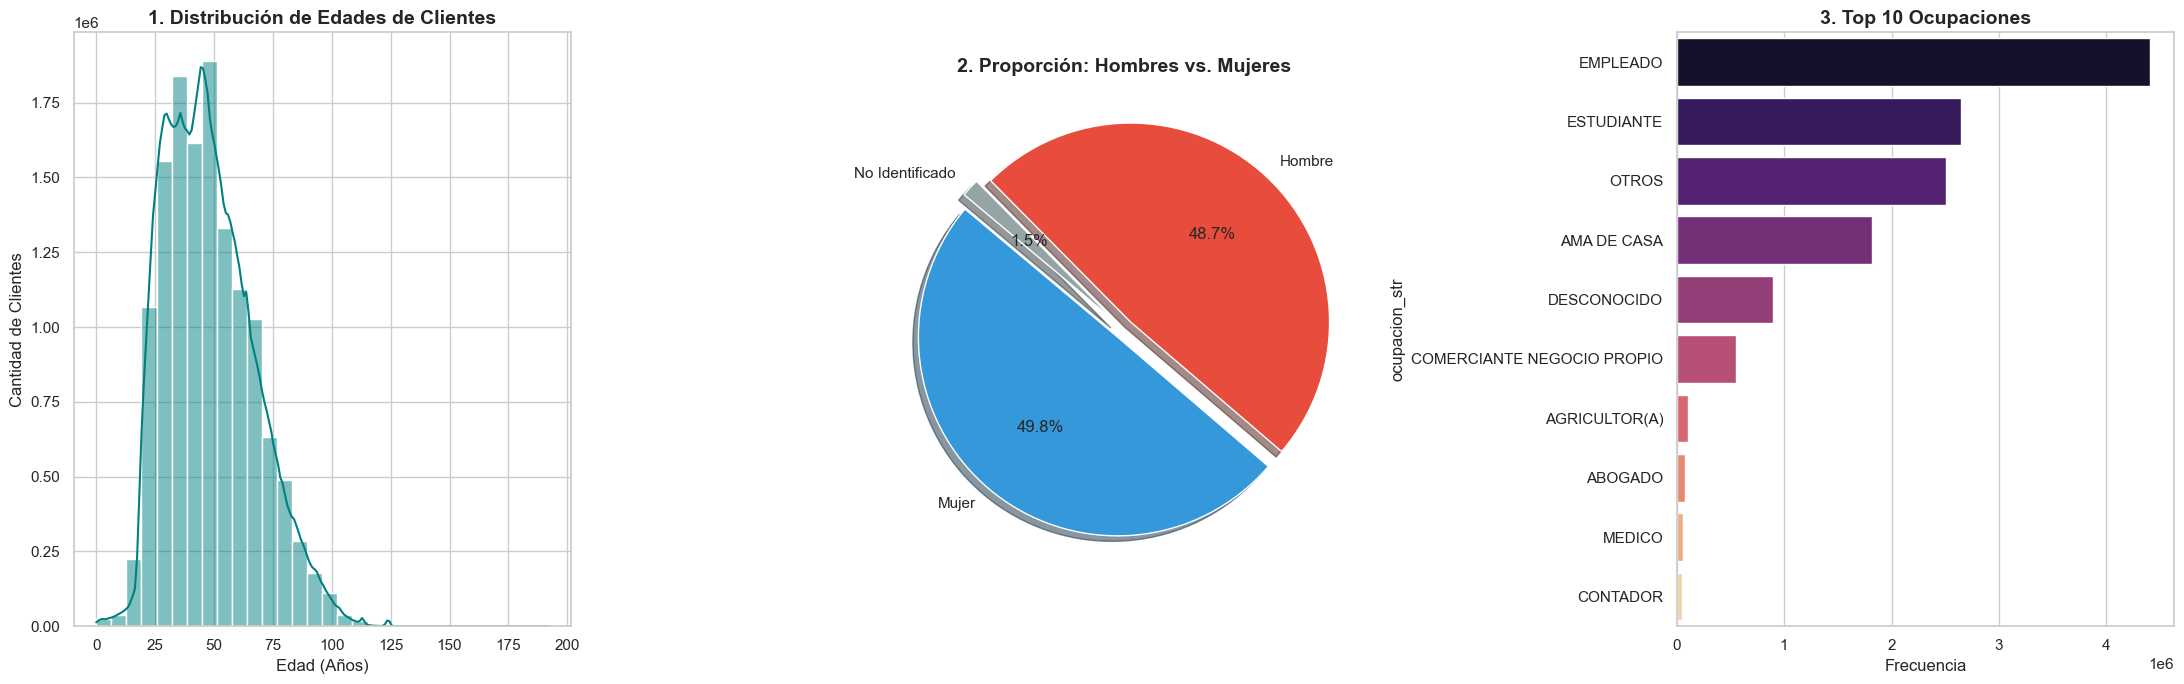


TABLA: DISTRIBUCIÓN POR FUENTE DE INGRESO


,Proporción (%)
clasificacion_fuente_ingreso,
NO TIENE O SIN INFO,36.08%
ASALARIADO,34.40%
REMESA EXTERIOR,11.21%
ASALARIADO NO COTIZANTE,6.99%
ESTUDIANTE,4.17%
SALVADORENO DEL EXTERIOR,3.38%
AMA DE CASA,2.69%
OTROS TIPOS DE CLIENTE,0.85%
RENTISTA,0.13%



DATOS CLAVE PARA EL REPORTE FINAL
• Edad promedio de la cartera: 48.1 años
• Ocupación predominante: EMPLEADO
• Fuente de ingreso principal: NO TIENE O SIN INFO


In [51]:
# A. Decodificamos y Mapeamos Género 
if 'genero' in df_clientes.columns:
    # Verificamos si los datos vienen como bytes y decodificamos si es necesario
    sample = df_clientes['genero'].iloc[0]
    if isinstance(sample, bytes):
        df_clientes['genero_str'] = df_clientes['genero'].str.decode('utf-8')
    else:
        df_clientes['genero_str'] = df_clientes['genero']

    df_clientes['genero_label'] = df_clientes['genero_str'].map({
        'M': 'Hombre', 
        'F': 'Mujer'
    }).fillna('No Identificado')

# B. Configuración del tablero de visualización
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# --- Pregunta 1: Distribución de Edades ---
sns.histplot(df_clientes['edad'].dropna(), bins=30, kde=True, color='teal', ax=axes[0])
axes[0].set_title('1. Distribución de Edades de Clientes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Edad (Años)')
axes[0].set_ylabel('Cantidad de Clientes')

# --- Pregunta 2: Proporción de Género ---
generos = df_clientes['genero_label'].value_counts()
axes[1].pie(generos, labels=generos.index, autopct='%1.1f%%', startangle=140, 
            colors=['#3498db', '#e74c3c', '#95a5a6'], explode=[0.05]*len(generos), shadow=True)
axes[1].set_title('2. Proporción: Hombres vs. Mujeres', fontsize=14, fontweight='bold')

# --- Pregunta 3 (Parte A): Top 10 Ocupaciones ---
if isinstance(df_clientes['ocupacion'].iloc[0], bytes):
    df_clientes['ocupacion_str'] = df_clientes['ocupacion'].str.decode('utf-8')
else:
    df_clientes['ocupacion_str'] = df_clientes['ocupacion']

top_ocupaciones = df_clientes['ocupacion_str'].value_counts().head(10)
sns.barplot(x=top_ocupaciones.values, y=top_ocupaciones.index, hue=top_ocupaciones.index, palette='magma', ax=axes[2], legend=False)
axes[2].set_title('3. Top 10 Ocupaciones', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Frecuencia')

plt.tight_layout()
plt.show()

# --- Pregunta 3 (Parte B): Clasificación de Fuente de Ingreso ---
print("\n" + "="*50)
print("TABLA: DISTRIBUCIÓN POR FUENTE DE INGRESO")
print("="*50)

col_ingreso = 'clasificacion_fuente_ingreso'
if isinstance(df_clientes[col_ingreso].iloc[0], bytes):
    resumen_ingreso = df_clientes[col_ingreso].str.decode('utf-8').value_counts(normalize=True) * 100
else:
    resumen_ingreso = df_clientes[col_ingreso].value_counts(normalize=True) * 100

# Formateo manual para evitar el error de jinja2 (.style)
resumen_df = resumen_ingreso.to_frame(name='Proporción (%)')
resumen_df['Proporción (%)'] = resumen_df['Proporción (%)'].map("{:.2f}%".format)
display(resumen_df)

# Estadísticos resumen para el reporte
print("\n" + "="*50)
print("DATOS CLAVE PARA EL REPORTE FINAL")
print("="*50)
print(f"• Edad promedio de la cartera: {df_clientes['edad'].mean():.1f} años")
print(f"• Ocupación predominante: {top_ocupaciones.index[0]}")
print(f"• Fuente de ingreso principal: {resumen_ingreso.index[0]}")

--- Análisis Integral de la Tabla de Gestiones ---
1. Distribución por Canal:
canal
LINEA TELEFONICA    0.718257
WHATSAPP            0.281743
Name: proportion, dtype: float64

2. Distribución por Resultado (Top 20):
resultado
0002 Teléfono no contesta              216314
Se Envía Mensaje                        97656
0391 Deudor Proporciona datos           47829
0005 Comunicación Telefónica no log     34608
0847 Se dejó mensaje en buzón           25383
0037 Promesa de Pago                    23343
0008 Cliente solicita aclaración        13465
0092 Teléfono no Existe                 12594
0386 Telefono equivocado                10144
0001 Teléfono Ocupado                   10022
0387 Telefono fuera de servicio          7688
0006 Tercero proporciona Datos           6590
0003 Se dejó mensaje                     5500
0828 Recordatorio Promesa de Pago        4270
0855 Se Ofrece Refinanciamiento          3361
0104 Teléfono Suspendido                 2825
0036 Deudor/Codeudor/Fiador colgó T   

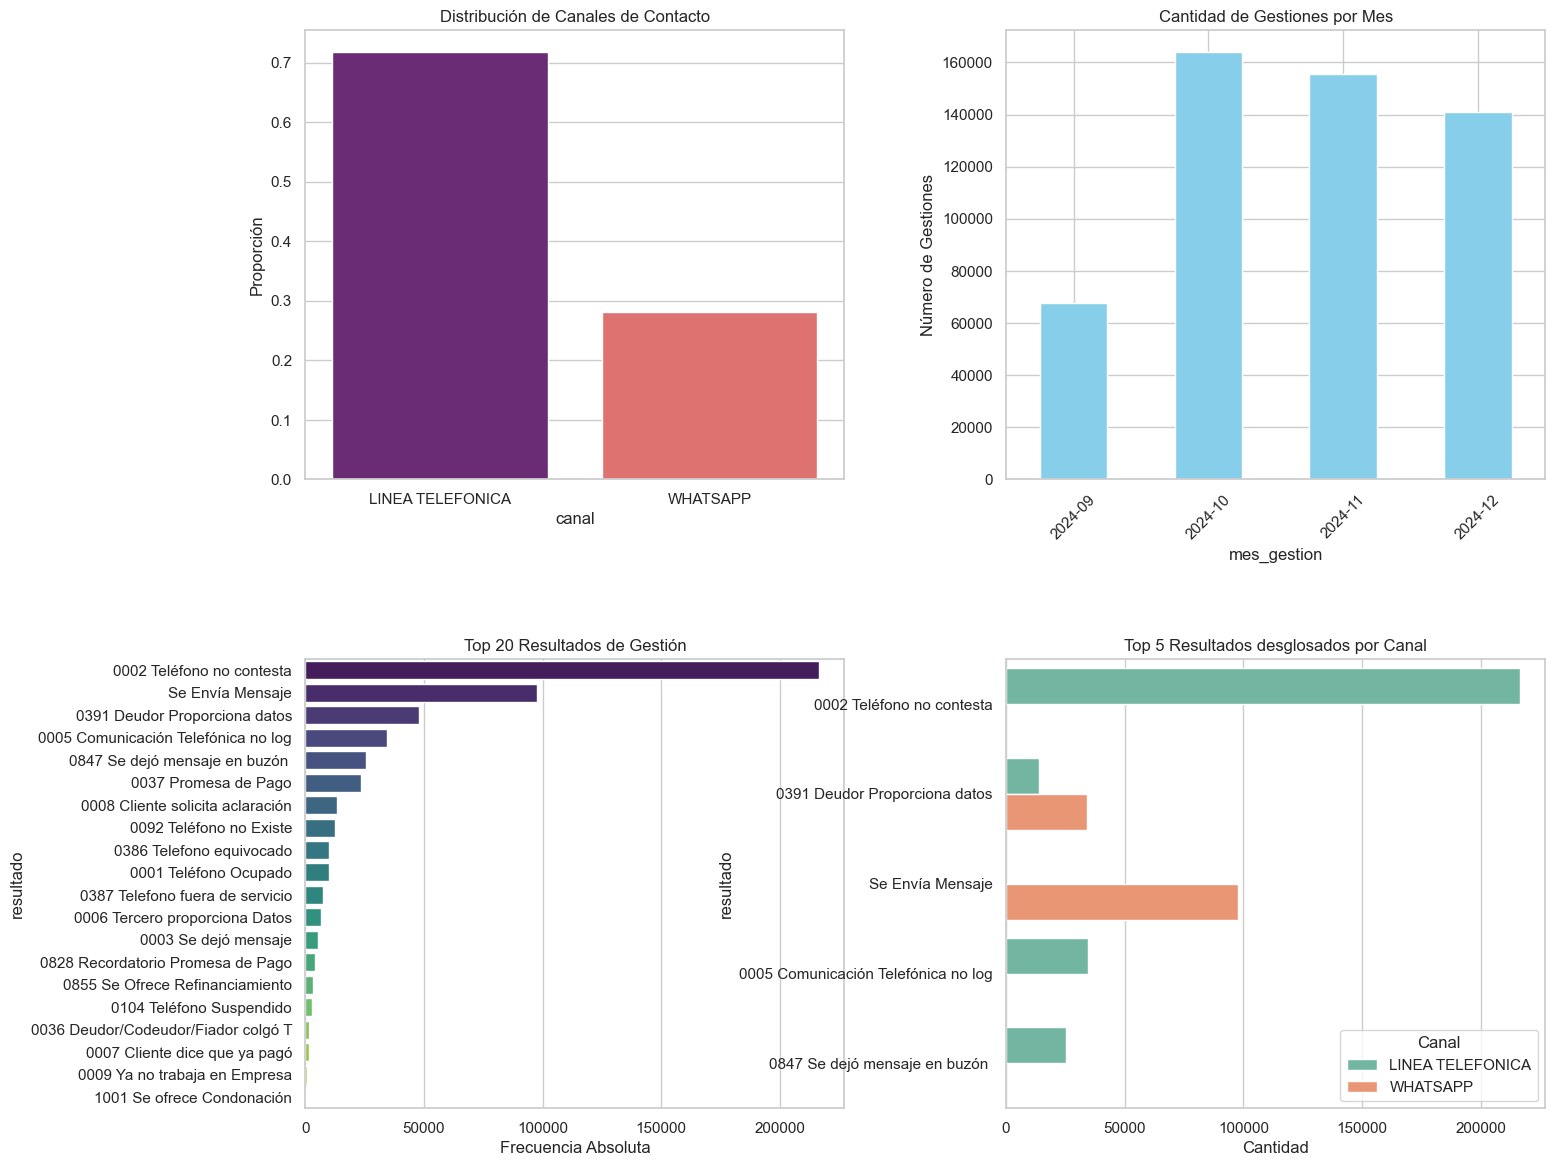


El Top 20 de resultados representa el 99.49% del total de gestiones.


In [52]:
print("--- Análisis Integral de la Tabla de Gestiones ---")

# 1. Distribución por Canal
print("1. Distribución por Canal:")
# Decodificamos si es necesario para el conteo
if isinstance(df_gestiones['canal'].iloc[0], bytes):
    canal_dist = df_gestiones['canal'].str.decode('utf-8').value_counts(normalize=True)
else:
    canal_dist = df_gestiones['canal'].value_counts(normalize=True)
print(canal_dist)

# 2. Análisis de Resultados (Top 20)
print("\n2. Distribución por Resultado (Top 20):")
if isinstance(df_gestiones['resultado'].iloc[0], bytes):
    top_20_resultados = df_gestiones['resultado'].str.decode('utf-8').value_counts().head(20)
else:
    top_20_resultados = df_gestiones['resultado'].value_counts().head(20)
print(top_20_resultados)

# --- VISUALIZACIONES ---

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Gráfico A: Distribución de Canales
sns.barplot(x=canal_dist.index, y=canal_dist.values, ax=axes[0,0], palette='magma', hue=canal_dist.index, legend=False)
axes[0,0].set_title('Distribución de Canales de Contacto')
axes[0,0].set_ylabel('Proporción')

# Gráfico B: Gestiones por Mes
col_fecha_gest = 'timestamp_gestion' 
df_gestiones['mes_gestion'] = df_gestiones[col_fecha_gest].dt.to_period('M')
df_gestiones.groupby('mes_gestion').size().plot(kind='bar', ax=axes[0,1], color='skyblue')
axes[0,1].set_title('Cantidad de Gestiones por Mes')
axes[0,1].set_ylabel('Número de Gestiones')
axes[0,1].tick_params(axis='x', rotation=45)

# Gráfico C: Top 20 Resultados
sns.barplot(y=top_20_resultados.index, x=top_20_resultados.values, ax=axes[1,0], palette='viridis', hue=top_20_resultados.index, legend=False)
axes[1,0].set_title('Top 20 Resultados de Gestión')
axes[1,0].set_xlabel('Frecuencia Absoluta')

# Gráfico D: Top 5 por Canal
top_5_res = top_20_resultados.head(5).index
# Preparamos una copia temporal decodificada para este gráfico
df_temp = df_gestiones.copy()
if isinstance(df_temp['canal'].iloc[0], bytes):
    df_temp['canal'] = df_temp['canal'].str.decode('utf-8')
if isinstance(df_temp['resultado'].iloc[0], bytes):
    df_temp['resultado'] = df_temp['resultado'].str.decode('utf-8')

df_top5 = df_temp[df_temp['resultado'].isin(top_5_res)]
sns.countplot(y='resultado', hue='canal', data=df_top5, ax=axes[1,1], palette='Set2')
axes[1,1].set_title('Top 5 Resultados desglosados por Canal')
axes[1,1].set_xlabel('Cantidad')
axes[1,1].legend(title='Canal')

plt.show()

total_registros = len(df_gestiones)
suma_top_20 = top_20_resultados.sum()
print(f"\nEl Top 20 de resultados representa el {(suma_top_20/total_registros):.2%} del total de gestiones.")

1.5 Limpieza inicial de datos

In [53]:
def clean_and_standardize_ids(df, id_column_name):
    """
    Limpia nulos, elimina notacion cientifica y estandariza IDs a texto.
    """
    # 1. Eliminar filas con ID nulo (No utiles para cruze de datos)
    initial_rows = len(df)
    df = df.dropna(subset=[id_column_name]).copy()
    
    # 2. Conversion: de Float/Int a String sin decimales
    # Usamos Int64 para asegurar que 1.0 se convierta en "1" y no en "1.0"
    df[id_column_name] = df[id_column_name].astype(float).astype('Int64').astype(str)
    
    # 3. Limpiar posibles espacios en blanco
    df[id_column_name] = df[id_column_name].str.strip()
    
    print(f"Dataset procesado. Filas originales: {initial_rows} | Filas finales: {len(df)}")
    return df

def decode_dataframe_objects(df):
    """
    Recorre columnas de tipo objeto y decodifica formatos de bytes a string.
    """
    for col in df.select_dtypes(include=['object']).columns:
        # Verificamos si el primer elemento es de tipo bytes
        sample = df[col].dropna().iloc[0] if not df[col].dropna().empty else None
        if isinstance(sample, bytes):
            df[col] = df[col].str.decode('utf-8')
    return df

# --- EJECUCION DE TRANSFORMACIONES ---

# Transformacion de Variable Respuesta a Binario (Clase Positiva: linea_movil)
print("Estandarizando Dataset: Target")
df_target = clean_and_standardize_ids(df_target, 'id_masked')
df_target = decode_dataframe_objects(df_target)
df_target['target'] = (df_target['mejor_canal_contacto'] == 'linea_movil').astype(int)

print("\nEstandarizando Dataset: Clientes")
# Nota: id_masked ya es int64 aqui, pero lo pasamos a string para el cruce
df_clientes = clean_and_standardize_ids(df_clientes, 'id_masked')

print("\nEstandarizando Dataset: OOT")
# Normalizamos el nombre de la columna a 'id_masked' para consistencia
df_oot = df_oot.rename(columns={'ID': 'id_masked'})
df_oot = clean_and_standardize_ids(df_oot, 'id_masked')

# Filtrado de Clientes para optimizar memoria antes de decodificar
print("\nFiltrando universo de clientes relevantes...")
relevant_ids = set(df_target['id_masked']).union(set(df_oot['id_masked']))
df_clientes_filtered = df_clientes[df_clientes['id_masked'].isin(relevant_ids)].copy()

# Ahora decodificamos solo los clientes que nos interesan
df_clientes_filtered = decode_dataframe_objects(df_clientes_filtered)

print(f"\nProceso completado. Clientes filtrados listos: {len(df_clientes_filtered)}")

Estandarizando Dataset: Target
Dataset procesado. Filas originales: 201979 | Filas finales: 201978

Estandarizando Dataset: Clientes


C:\Users\Nicole\AppData\Local\Temp\ipykernel_23884\319413369.py:23: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  for col in df.select_dtypes(include=['object']).columns:


Dataset procesado. Filas originales: 13556034 | Filas finales: 13556034

Estandarizando Dataset: OOT
Dataset procesado. Filas originales: 41957 | Filas finales: 41957

Filtrando universo de clientes relevantes...


C:\Users\Nicole\AppData\Local\Temp\ipykernel_23884\319413369.py:23: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  for col in df.select_dtypes(include=['object']).columns:



Proceso completado. Clientes filtrados listos: 458700


1.6 Verificacion Post-Limpieza y de cobertura (join)

In [54]:
# 1. Verificar Textos en Clientes (antes b'I')
print("Muestra de columna 'codigo_tipo_cliente' en Clientes:")
print(df_clientes['codigo_tipo_cliente'].head(3))

# 2. Verificar IDs en Target 
print("\nMuestra de IDs en Target:")
print(df_target['id_masked'].head(3))

# 3. Verificar Tipo de Dato Final para Merges
print(f"\nTipo de dato final ID (Target): {df_target['id_masked'].dtype}")

# 4. Dimensiones Finales
print(f"\nDimensiones finales Target: {df_target.shape}")

def verify_join_coverage(df_left, df_right, id_col):
    """
    Calcula matematicamente el exito potencial de la union.
    """
    ids_left = set(df_left[id_col])
    ids_right = set(df_right[id_col])
    
    intersection = ids_left.intersection(ids_right)
    coverage = (len(intersection) / len(ids_left)) * 100
    
    print(f"--- ANALISIS DE COBERTURA: ---")
    print(f"IDs en Target/OOT: {len(ids_left)}")
    print(f"IDs encontrados en Clientes: {len(intersection)}")
    print(f"Cobertura: {coverage:.2f}%")
    return coverage

print("Verificando Train (Target vs Clientes):")
coverage_train = verify_join_coverage(df_target, df_clientes_filtered, 'id_masked')

print("\nVerificando Test (OOT vs Clientes):")
coverage_oot = verify_join_coverage(df_oot, df_clientes_filtered, 'id_masked')

Muestra de columna 'codigo_tipo_cliente' en Clientes:
0    b'I'
1    b'I'
2    b'I'
Name: codigo_tipo_cliente, dtype: object

Muestra de IDs en Target:
0     1380371239760879104
1    -8020749057517333504
2    -6761267010954018816
Name: id_masked, dtype: str

Tipo de dato final ID (Target): str

Dimensiones finales Target: (201978, 4)
Verificando Train (Target vs Clientes):
--- ANALISIS DE COBERTURA: ---
IDs en Target/OOT: 106419
IDs encontrados en Clientes: 106418
Cobertura: 100.00%

Verificando Test (OOT vs Clientes):
--- ANALISIS DE COBERTURA: ---
IDs en Target/OOT: 41957
IDs encontrados en Clientes: 41957
Cobertura: 100.00%


1.7 Analisis de consistencia temporal

In [55]:
# --- SCRIPT: VERIFICACIÓN DE CONSISTENCIA TEMPORAL ---

print("--- DISTRIBUCIÓN TEMPORAL ---")

# 1. Distribución en Target
df_target['fin_mes'] = pd.to_datetime(df_target['fin_mes'])
print("Distribución de fechas en el Target (Entrenamiento):")
print(df_target['fin_mes'].dt.to_period('M').value_counts().sort_index())

# 2. Distribución de Clientes
print("\nDistribución de fechas en tabla Clientes:")
fechas_clientes = pd.to_datetime(df_clientes_filtered['fecha_proceso'])
print(fechas_clientes.dt.to_period('M').value_counts().sort_index())

# 3. Comparación de horizontes para detectar Leakage
try:
    # Detectar columna de fecha en gestiones de forma dinámica
    col_fecha_gest = 'fecha_contacto' if 'fecha_contacto' in df_gestiones.columns else df_gestiones.select_dtypes(include=['datetime64']).columns[0]
    
    df_gestiones[col_fecha_gest] = pd.to_datetime(df_gestiones[col_fecha_gest])
    
    max_target = df_target['fin_mes'].max()
    max_gestiones = df_gestiones[col_fecha_gest].max()

    print(f"\nÚltimo Target: {max_target.date()}")
    print(f"Última Gestión: {max_gestiones.date()}")

    if max_gestiones > max_target:
        print("⚠️ ALERTA DE LEAKAGE: Se detectan gestiones posteriores al Target.")
    else:
        print("OK: Los periodos de gestión están alineados con el rango del target.")
        
except NameError:
    print("\nℹ Nota: df_gestiones no está en memoria.")
except Exception as e:
    print(f"\nError en la comparación: {e}")

--- DISTRIBUCIÓN TEMPORAL ---
Distribución de fechas en el Target (Entrenamiento):
fin_mes
2024-09    30828
2024-10    60370
2024-11    57327
2024-12    53453
Freq: M, Name: count, dtype: int64

Distribución de fechas en tabla Clientes:
fecha_proceso
2024-09    114671
2024-10    114677
2024-11    114676
2024-12    114676
Freq: M, Name: count, dtype: int64

Último Target: 2024-12-31
Última Gestión: 2024-12-31
⚠️ ALERTA DE LEAKAGE: Se detectan gestiones posteriores al Target.


1.8 Creacion de tablas ABT (Analytical base table)

In [56]:
def create_temporal_abt(df_target_base, df_clients_base):
    """
    Une el target con los datos demograficos asegurando consistencia temporal (mes a mes).
    """
    # 1. Estandarizar llaves temporales a formato Periodo (Año-Mes)
    # Creamos copias para no afectar los dataframes originales
    target_tmp = df_target_base.copy()
    clients_tmp = df_clients_base.copy()
    
    target_tmp['month_key'] = pd.to_datetime(target_tmp['fin_mes']).dt.to_period('M')
    clients_tmp['month_key'] = pd.to_datetime(clients_tmp['fecha_proceso']).dt.to_period('M')
    
    print(f"Iniciando cruce temporal para {len(target_tmp)} registros de entrenamiento...")
    
    # 2. Realizar el Merge por ID y Mes
    # Usamos inner para asegurar que cada ejemplo de entrenamiento tenga su foto demografica exacta
    abt_train = pd.merge(
        target_tmp, 
        clients_tmp, 
        on=['id_masked', 'month_key'], 
        how='inner'
    )
    
    print(f"ABT de Entrenamiento creada exitosamente con {len(abt_train)} filas.")
    return abt_train

def create_oot_prediction_table(df_oot_base, df_clients_base):
    """
    Prepara la tabla para la prediccion de Enero 2025 usando la ultima info (Diciembre 2024).
    """
    print("\nPreparando tabla OOT (Inferencia)...")
    
    # Obtenemos solo la foto de Diciembre 2024 de la maestra de clientes
    # Esto es lo mas cercano que tenemos para predecir Enero 2025
    latest_month = pd.to_datetime(df_clients_base['fecha_proceso']).max()
    df_last_photo = df_clients_base[pd.to_datetime(df_clients_base['fecha_proceso']) == latest_month].copy()
    
    print(f"Usando snapshot de: {latest_month.date()} para la base de inferencia.")
    
    # Union por ID
    abt_oot = pd.merge(df_oot_base, df_last_photo, on='id_masked', how='left')
    
    print(f"ABT OOT creada con {len(abt_oot)} filas.")
    return abt_oot

# --- EJECUCION ---

# 1. Generar Tabla Maestra de Entrenamiento (Train)
df_train_final = create_temporal_abt(df_target, df_clientes_filtered)

# 2. Generar Tabla Maestra de Evaluacion (OOT)
df_oot_final = create_oot_prediction_table(df_oot, df_clientes_filtered)

# 3. Guardado en la capa 'processed'
processed_dir = BASE_DIR / "data" / "processed"
processed_dir.mkdir(parents=True, exist_ok=True)

df_train_final.to_parquet(processed_dir / "abt_train.parquet", index=False)
df_oot_final.to_parquet(processed_dir / "abt_oot.parquet", index=False)

print(f"\nProceso finalizado. Archivos guardados en: {processed_dir}")

Iniciando cruce temporal para 201978 registros de entrenamiento...
ABT de Entrenamiento creada exitosamente con 201977 filas.

Preparando tabla OOT (Inferencia)...
Usando snapshot de: 2024-12-31 para la base de inferencia.
ABT OOT creada con 41957 filas.

Proceso finalizado. Archivos guardados en: c:\Users\Nicole\Documents\Proyecto_BA\data\processed
